In [ ]:
!git clone https://github.com/aldinash/CS4644-Project.git
!pip install lightning
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from utils.data_utils import SpacecraftDataset, train_transforms, valid_transforms
from utils.vis_utils import predict_mask, display_random_examples
from utils.seg_utils import IoU, SegModel
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path

from tqdm import tqdm

In [ ]:
path_to_data = "/content/drive/My Drive/Colab Notebooks/cs4644/project/data"
path_to_working = "/content/drive/My Drive/Colab Notebooks/cs4644/project/working"
DATA = Path(path_to_data)
WORKING=Path(path_to_working)

BATCH_SIZE=32

**DataSet**

Here we create a torch dataset for our data


In [ ]:
valid_transforms = A.Compose([A.Resize(520, 520), A.Normalize(), ToTensorV2()])

train_dataset = SpacecraftDataset(transforms=train_transforms, path_to_data=DATA)
valid_dataset = SpacecraftDataset(transforms=valid_transforms, path_to_data=DATA, split="val")
print(train_dataset.image_path)
print(len(train_dataset))


/content/drive/My Drive/Colab Notebooks/cs4644/project/data/images/train
2527


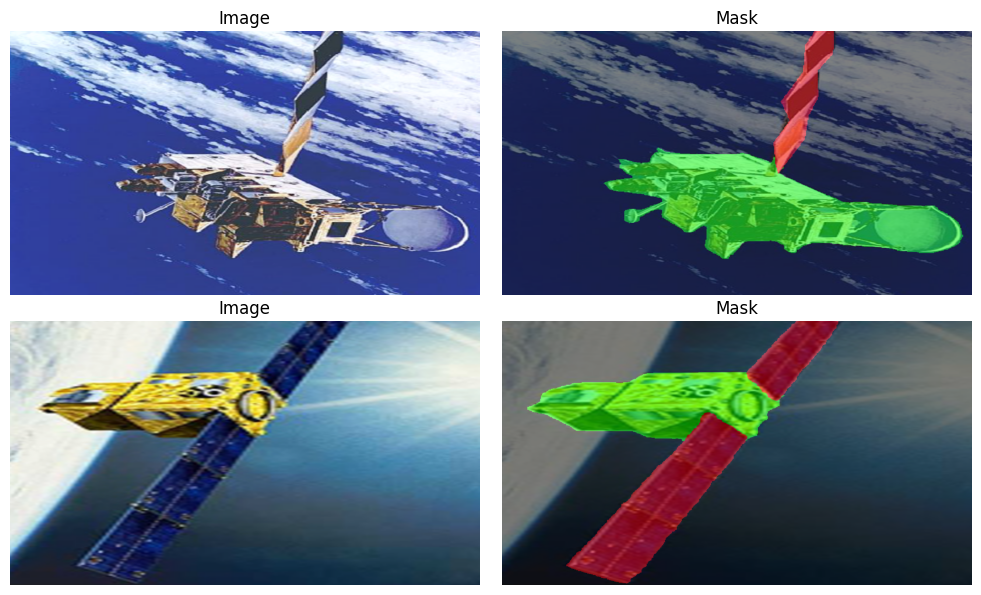

In [ ]:
display_random_examples(train_dataset)

In [ ]:
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights="DEFAULT")
model.classifier[4] = nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(10, 4, kernel_size=(1, 1), stride=(1, 1))
for params in model.parameters():
    params.requires_grad = True

all_params = sum(p.numel() for p in model.parameters())
train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"No of parameters: {all_params}")
print(f"No of trainable parameters: {train_params}")

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 209MB/s]

No of parameters: 11024772
No of trainable parameters: 11024772


In [12]:
wandb.login()
wandb_logger = WandbLogger(project='Spacecrafts', name="deeplabv3_mobilenet_v3_large_run4")

# The model
pl_model = SegModel(model, BATCH_SIZE, 0.02, train_dataset, valid_dataset)
checkpoint_callback = ModelCheckpoint(
    dirpath="/content/drive/My Drive/Colab Notebooks/cs4644/project/checkpoints", monitor='val_iou', mode='max')

# Pytorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=100,
    logger=wandb_logger,
    log_every_n_steps=10,
    callbacks=[
        checkpoint_callback,
        LearningRateMonitor('epoch'),
        EarlyStopping(monitor='val_iou', mode='max', patience=15),
    ],
)

# Batch size and initial learning rate estimation
tuner = pl.tuner.Tuner(trainer)
tuner.scale_batch_size(pl_model)
tuner.lr_find(pl_model)

# Model training
trainer.fit(pl_model, ckpt_path='/content/drive/My Drive/Colab Notebooks/cs4644/project/checkpoints/epoch=29-step=2340.ckpt')

# Saving the weights
torch.save(pl_model.state_dict(), WORKING/'spacecrafts.pt')

wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3` reached.
INFO:pytorch_lightning.utilities.rank_zero:Batch size 2 succeeded, trying batch size 4
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3` reached.
INFO:pytorch_lightning.utilities.rank_zero:Batch size 4 succeeded, 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 89 steps due to diverging loss.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 1.0964781961431852e-07
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_7055fbba-7d82-40b4-a231-6c00541e2610.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_7055fbba-7d82-40b4-a231-6c00541e2610.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/My Drive/Colab Notebooks/cs4644/project/checkpoints/epoch=29-step=2340.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | net       | DeepLabV3        | 11.0 M | train
1 | criterion | CrossEntropyLoss | 0      | train
------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
lr-Adamax,██▇▄▃▁█▇▆▄▂▁█▇▆▃▂▂▁█▆▄▃▂█▆▄▃▂▂██▇▇▆▂▂▁▇▆
train_iou,▃▂▃▅▅▃▇▁▃▆▇▆▇▃▃▆▄▆▆▆▅▅▅▅▄▆▆▇▆█▆▂▅▆▇▇▆▇▅▅
train_loss,▆██▄▃▃▄▇▅▃▄▂▄▃▃▅▄▃▂▁▄▃▃▃▂▃▃▂▅▂▃▂▁▁▂▂▁▂▄▃
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_iou,▁▃▃▄▃▆▆▄▂▂▅▆▆▆▃▄▆▆▇▇▆▆▅▆▆▇▇███▅▄▆▇▆▇▇▆▆█
val_loss,▇▃▂▂▃▁▂▁▄▄▃▂▂▆▁▂▄▄▃▃▄▃▄▄▃▃▃█▄▂▃▄▃▃▃▃▄▇▄▄
epoch,94
lr-Adamax,0.0018
train_iou,0.89559
train_loss,0.04104


In [17]:
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(
   weights='DEFAULT')
model.classifier[4] = nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(10, 4, kernel_size=(1, 1), stride=(1, 1))

pl_model = SegModel(model, BATCH_SIZE, 0.02, train_dataset, valid_dataset)
pl_model.load_state_dict(torch.load(WORKING/'spacecrafts.pt'))

trainer = pl.Trainer()

<ipython-input-17-d987f0401730>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pl_model.load_state_dict(torch.load(WORKING/'spacecrafts.pt'))
INFO:pytorch_lightning.utilit

In [18]:
trainer.validate(pl_model,
                 dataloaders=pl_model.val_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.7576053142547607     │
│         val_loss          │    0.10009562224149704    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.10009562224149704, 'val_iou': 0.7576053142547607}]

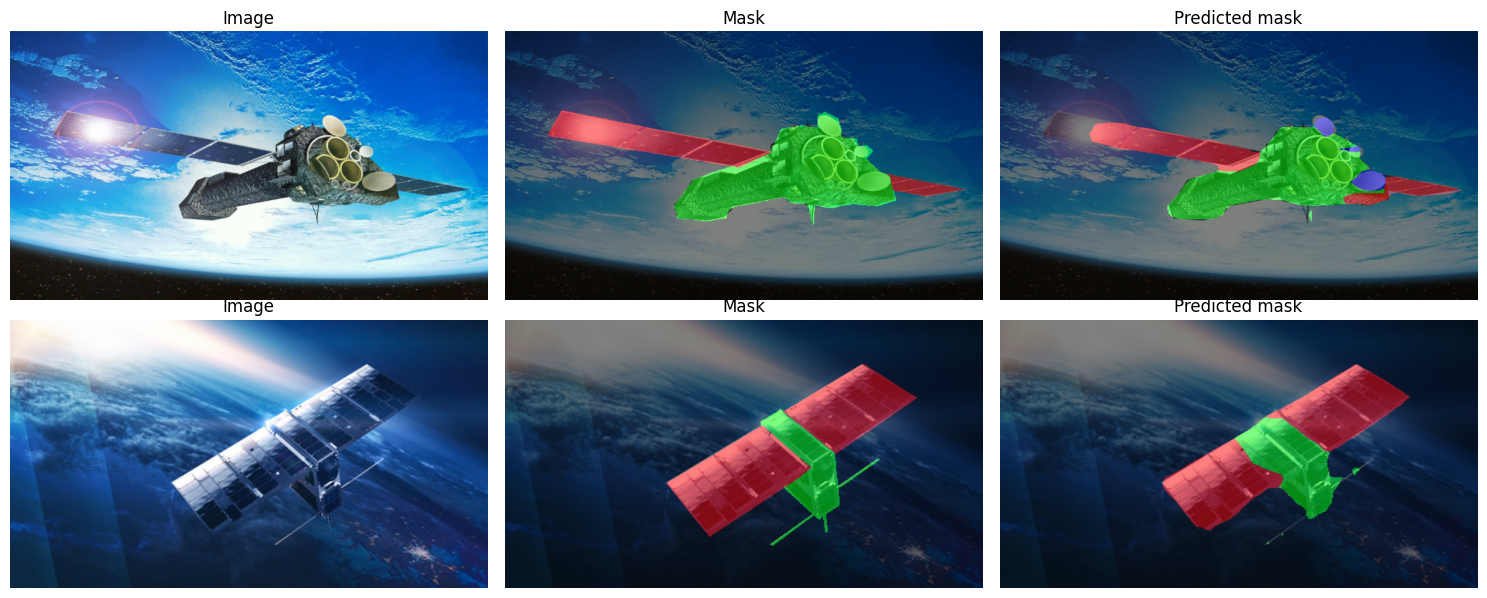

In [19]:
display_random_examples(valid_dataset, 2, pl_model)